# **Assignment 4**
Μη επιβλεπόμενη μάθηση – Συσταδοποίηση

### Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation, Flatten
from keras import backend as K
from sklearn import cluster

### Define a performance evaluation function

In [ ]:
def performance_score(input_values, cluster_indexes):
    try:
        silh_score = metrics.silhouette_score(input_values, cluster_indexes)
        print(' .. Silhouette Coefficient score is {:.2f}'.format(silh_score))
        #print( ' ... -1: incorrect, 0: overlapping, +1: highly dense clusts.')
    except:
        print(' .. Warning: could not calculate Silhouette Coefficient score.')
        silh_score = -999

    try:
        ch_score =\
         metrics.calinski_harabasz_score(input_values, cluster_indexes)
        print(' .. Calinski-Harabasz Index score is {:.2f}'.format(ch_score))
        #print(' ... Higher the value better the clusters.')
    except:
        print(' .. Warning: could not calculate Calinski-Harabasz Index score.')
        ch_score = -999

    try:
        db_score = metrics.davies_bouldin_score(input_values, cluster_indexes)
        print(' .. Davies-Bouldin Index score is {:.2f}'.format(db_score))
        #print(' ... 0: Lowest possible value, good partitioning.')
    except:
        print(' .. Warning: could not calculate Davies-Bouldin Index score.')
        db_score = -999

    return silh_score, ch_score, db_score


### Import the dataset

In [ ]:
print('>>> Downloading dataset...')
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('>>> Dataset downloaded...')

>>> Downloading dataset...
4422102/4422102 [==============================] - 0s 0us/step
>>> Dataset downloaded...


### Split into train, validation and test sets

In [ ]:
print('>>> Splitting dataset...')
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # 0.2 x 0.86 = 0.172
print('>>> Splitting done...')
print(f'>>> We have {len(y_train)} train images, {len(y_validate)} validation images and {len(y_test)} test images...')

>>> Splitting dataset...
>>> Splitting done...
>>> We have 48000 train images, 12000 validation images and 10000 test images...


### Create a CNN autoencoder

In [ ]:
print('>>> Creating the CNN autoencoder...')
model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same',\
                 activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

print('>>> Model created...')
print('>>> Checking model architecture...')
model.summary()

>>> Creating the CNN autoencoder...
>>> Model created...
>>> Checking model architecture...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 14)        140       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 14)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 14)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 7)         889       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 7)          0         
 2D)                                                             
                              

### Compile and train the autoencoder

In [ ]:
print('>>> Compiling the model...')
model.compile(optimizer='adam',
              loss=tf.keras.losses.mse,
              # categorical_crossentropy
              metrics=['accuracy'])
print('>>> Model compiled...')

print('>>> Training the model...')
print('>>> This may take a while...')
model.fit(X_train, X_train, epochs=3, validation_data=(X_validate, X_validate))
print('>>> Model training done...')

>>> Compiling the model...
>>> Model compiled...
>>> Training the model...
>>> This may take a while...
Epoch 1/3
1500/1500 [==============================] - 100s 66ms/step - loss: 2024.9103 - accuracy: 0.3693 - val_loss: 1637.0552 - val_accuracy: 0.4499
Epoch 2/3
1500/1500 [==============================] - 109s 73ms/step - loss: 1504.0088 - accuracy: 0.4371 - val_loss: 1531.7629 - val_accuracy: 0.4577
Epoch 3/3
1500/1500 [==============================] - 112s 75ms/step - loss: 1408.7506 - accuracy: 0.4417 - val_loss: 1381.9539 - val_accuracy: 0.4615
>>> Model training done...


### Use the autoencoder over test data

In [ ]:
print('>>> Using the trained autoencoder over test data...')
restored_testing_dataset = model.predict(X_test)
print('>>> Autoencoder used over test data...')

>>> Using the trained autoencoder over test data...
313/313 [==============================] - 5s 15ms/step
>>> Autoencoder used over test data...


### Plot original and reconstructed images

>>> Plotting original (top) and reconstructed (bottom) images...


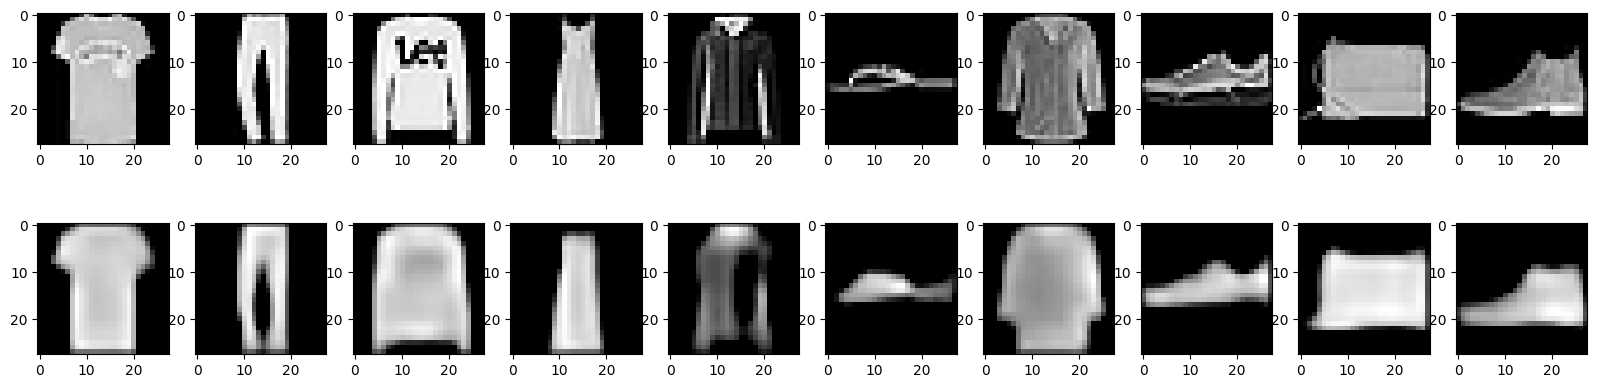

In [ ]:
print('>>> Plotting original (top) and reconstructed (bottom) images...')
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[index].reshape((28,28)))
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(restored_testing_dataset[index].reshape((28,28)))
    plt.gray()

### Exctract the encoder block

In [ ]:
print('>>> Extracting encoder...')
encoder = K.function([model.layers[0].input],[model.layers[4].output])
print('>>> Encoder extracted...')

>>> Extracting encoder...
>>> Encoder extracted...


### Normalizing pixel values

In [ ]:
# Normalize pixel values to be between 0 and 1
print('>>> Normalizing pixel values...')
train_norm_images, test_norm_images = X_train / 255.0, X_test / 255.0
print('>>> Pixel values normalized...')

>>> Normalizing pixel values...
>>> Pixel values normalized...


### Convert images to projected data

In [ ]:
print('>>> Converting images to projected data...')
test_encoded_images = encoder([X_test])[0].reshape(-1,7*7*7)
print('>>> Images converted...')

>>> Converting images to projected data...
>>> Images converted...


Normalized pixel values

In [ ]:
print('>>> Converting images to projected data...')
test_norm_images = encoder([test_norm_images])[0].reshape(-1,7*7*7)
test_norm_images = test_norm_images / np.max(test_norm_images)
print('>>> Images converted...')

>>> Converting images to projected data...
>>> Images converted...


### Mini-Batch K-Means clustering (encoded pixel values)

In [ ]:
print('>>> Mini-Batch K-Means clustering with encoded pixel values...')

mbkm = cluster.MiniBatchKMeans(n_init=3)
mbkm.fit(test_encoded_images)
mbkm_labels_enc = mbkm.labels_
mbkm_pred_labels_enc = mbkm.predict(test_encoded_images)

print('>>> Mini-Batch K-Means clustering with encoded pixel values finished...')

>>> Mini-Batch K-Means clustering with encoded pixel values...
>>> Mini-Batch K-Means clustering with encoded pixel values finished...


#### Visualizations

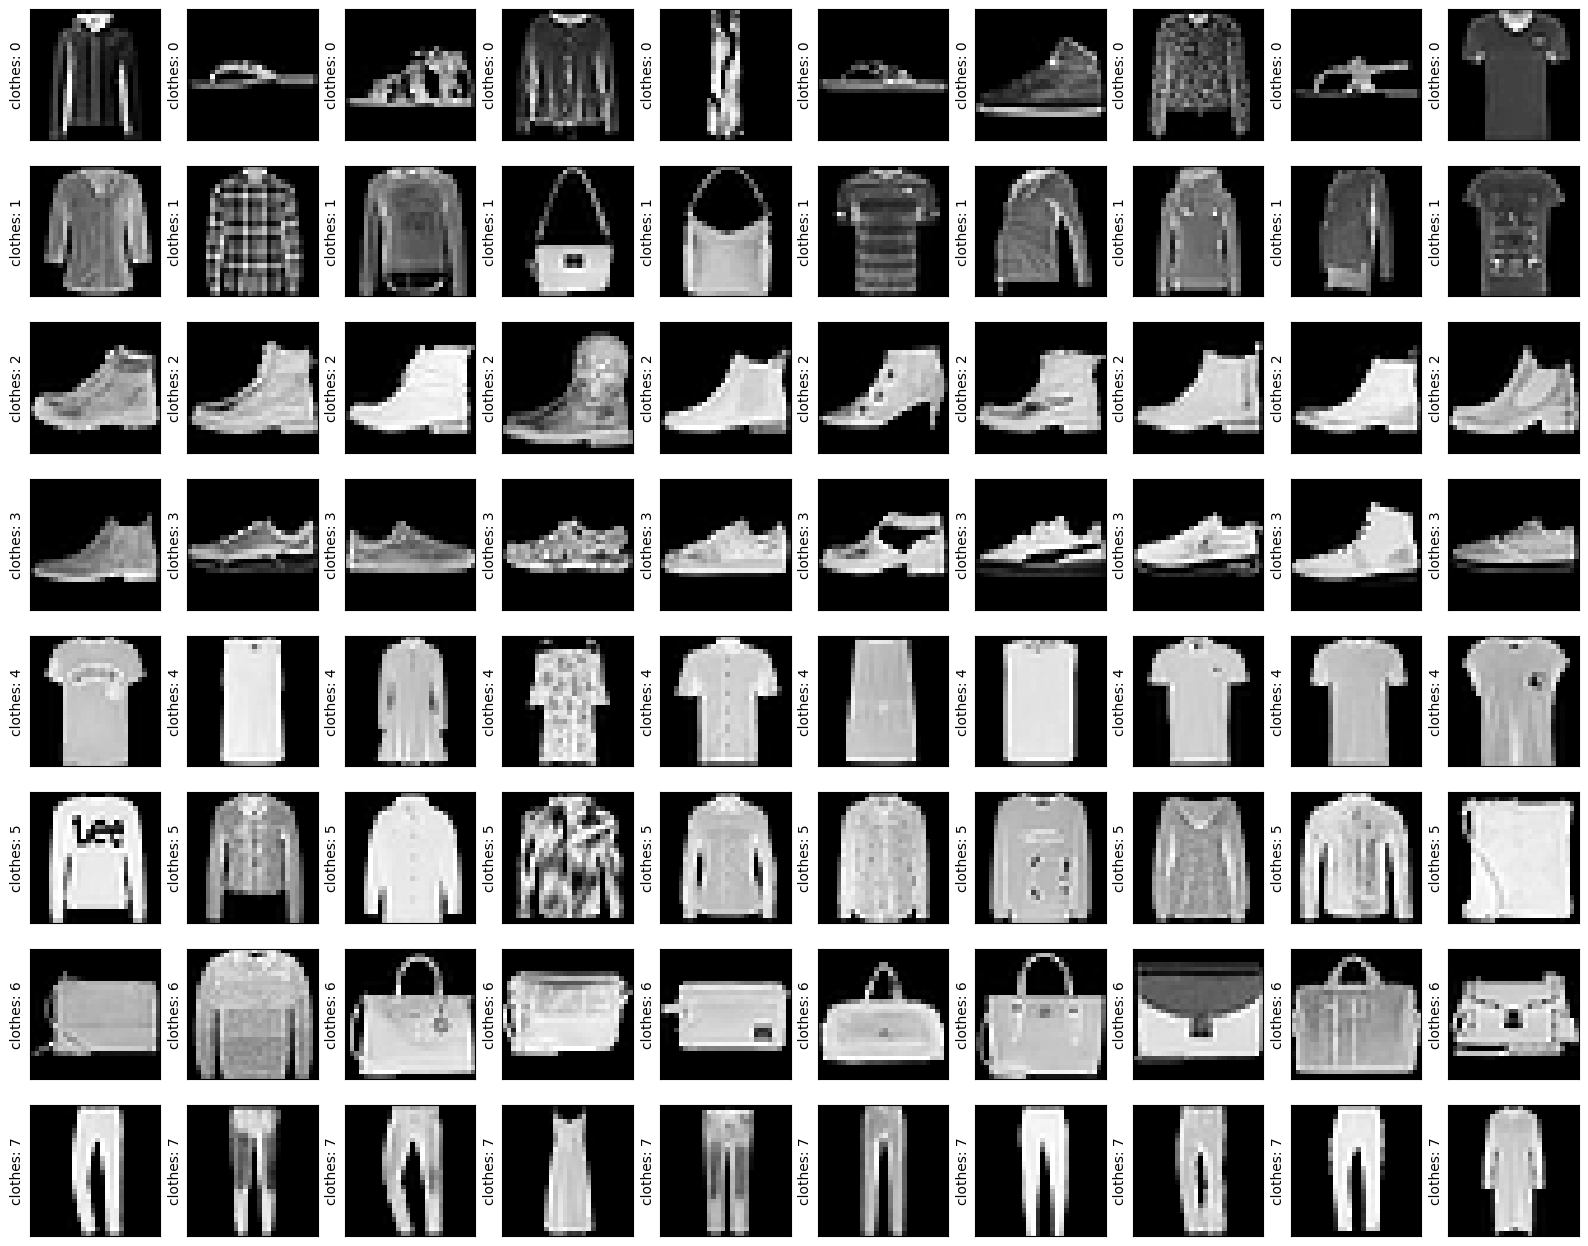

In [ ]:
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(len(mbkm_labels_enc)):
    for c, val in enumerate(X_test[mbkm_pred_labels_enc == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('clothes: '+str(clusterIdx))

#### Performance scores

In [ ]:
print('>>> Calculating performance scores for Mini-Batch K-Means clustering with encoded pixel values...')
mbkm_silh_score_enc, mbkm_ch_score_enc, mbkm_db_score_enc = performance_score(y_test.reshape(-1, 1), mbkm_labels_enc)
mbkm_vm_score_enc = metrics.v_measure_score(mbkm_labels_enc, mbkm_pred_labels_enc)
print(f' .. V-measure score is {mbkm_vm_score_enc}')

>>> Calculating performance scores for Mini-Batch K-Means clustering with encoded pixel values...
 .. Silhouette Coefficient score is -0.02
 .. Calinski-Harabasz Index score is 2081.59
 .. Davies-Bouldin Index score is 13.78
 .. V-measure score is 1.0


### Mini-Batch K-Means clustering (normalized pixel values)

In [ ]:
print('>>> Mini-Batch K-Means clustering with normalized pixel values...')

mbkm = cluster.MiniBatchKMeans(n_init=3)
mbkm.fit(test_norm_images)
mbkm_labels_norm = mbkm.labels_
mbkm_pred_labels_norm = mbkm.predict(test_norm_images)

print('>>> Mini-Batch K-Means clustering with normalized pixel values finished...')

>>> Mini-Batch K-Means clustering with normalized pixel values...
>>> Mini-Batch K-Means clustering with normalized pixel values finished...


#### Visualizations

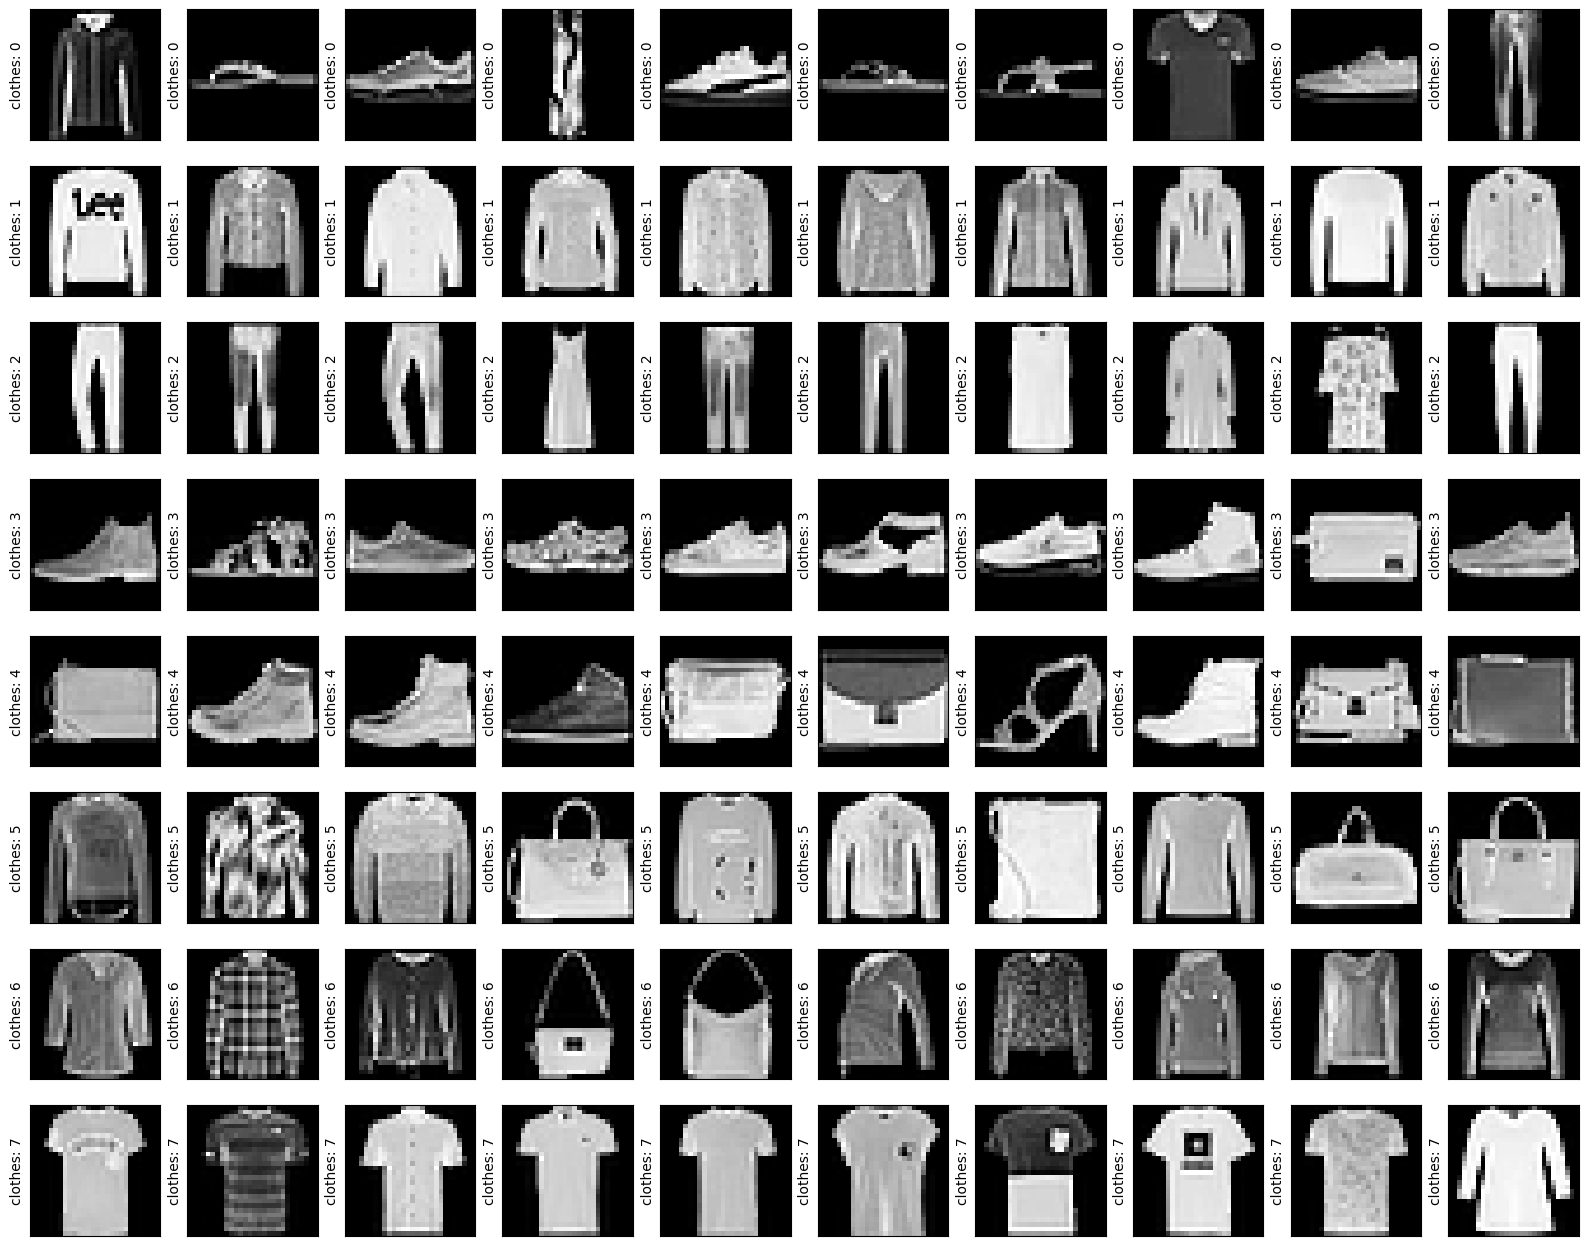

In [ ]:
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(len(mbkm_labels_norm)):
    for c, val in enumerate(X_test[mbkm_pred_labels_norm == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('clothes: '+str(clusterIdx))

#### Performance scores

In [ ]:
print('>>> Calculating performance scores for Mini-Batch K-Means clustering with normalized pixel values...')
mbkm_silh_score_norm, mbkm_ch_score_norm, mbkm_db_score_norm = performance_score(y_test.reshape(-1, 1), mbkm_labels_norm)
mbkm_vm_score_norm = metrics.v_measure_score(mbkm_labels_norm, mbkm_pred_labels_norm)
print(f' .. V-measure score is {mbkm_vm_score_norm}')

>>> Calculating performance scores for Mini-Batch K-Means clustering with normalized pixel values...
 .. Silhouette Coefficient score is -0.11
 .. Calinski-Harabasz Index score is 1431.39
 .. Davies-Bouldin Index score is 7.50
 .. V-measure score is 1.0


### Hierarchical clustering (encoded pixel values)

In [ ]:
print('>>> Hierarchical clustering with encoded pixel values...')

aggl = cluster.AgglomerativeClustering()
aggl.fit(test_encoded_images)
aggl_labels_enc = aggl.labels_
aggl_pred_labels_enc = aggl.fit_predict(test_encoded_images)

print('>>> Hierarchical clustering with encoded pixel values finished...')

>>> Hierarchical clustering with encoded pixel values...
>>> Hierarchical clustering with encoded pixel values finished...


#### Visualizations

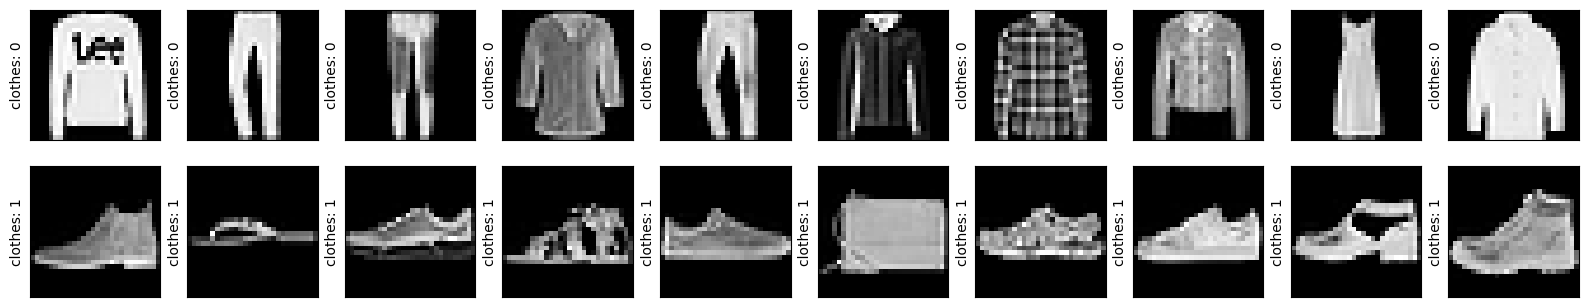

In [ ]:
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(len(aggl_labels_enc)):
    for c, val in enumerate(X_test[aggl_pred_labels_enc == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('clothes: '+str(clusterIdx))

#### Performance scores

In [ ]:
print('>>> Calculating performance scores for Hierarchical clustering with encoded pixel values...')
aggl_silh_score_enc, aggl_ch_score_enc, aggl_db_score_enc = performance_score(y_test.reshape(-1, 1), aggl_labels_enc)
aggl_vm_score_enc = metrics.v_measure_score(aggl_labels_enc, aggl_pred_labels_enc)
print(f' .. V-measure score is {aggl_vm_score_enc}')

>>> Calculating performance scores for Hierarchical clustering with encoded pixel values...
 .. Silhouette Coefficient score is 0.35
 .. Calinski-Harabasz Index score is 7302.85
 .. Davies-Bouldin Index score is 0.85
 .. V-measure score is 1.0


### Hierarchical clustering (normalized pixel values)

In [ ]:
print('>>> Hierarchical clustering with normalized pixel values...')

aggl = cluster.AgglomerativeClustering()
aggl.fit(test_norm_images)
aggl_labels_norm = aggl.labels_
aggl_pred_labels_norm = aggl.fit_predict(test_norm_images)

print('>>> Hierarchical clustering with normalized pixel values finished...')

>>> Hierarchical clustering with normalized pixel values...
>>> Hierarchical clustering with normalized pixel values finished...


#### Visualizations

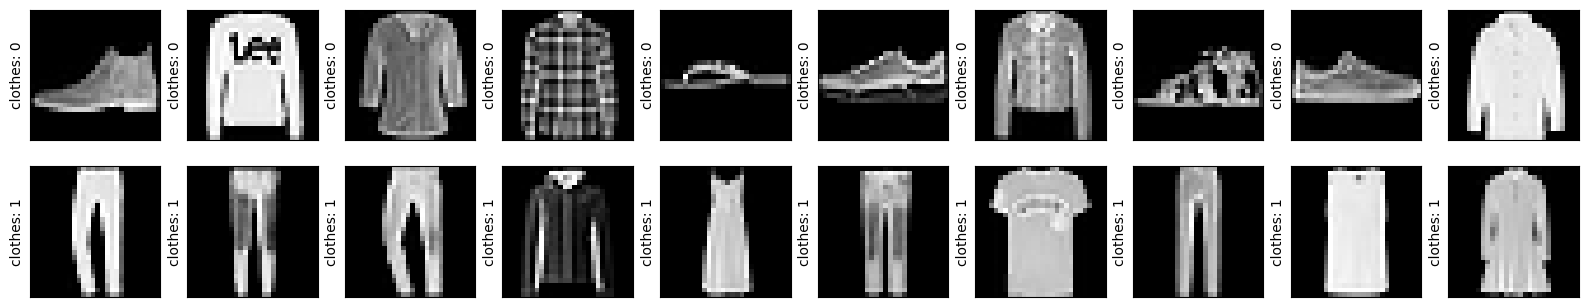

In [ ]:
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(len(aggl_labels_norm)):
    for c, val in enumerate(X_test[aggl_pred_labels_norm == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('clothes: '+str(clusterIdx))

#### Perfomance scores

In [ ]:
print('>>> Calculating performance scores for Hierarchical clustering with normalized pixel values...')
aggl_silh_score_norm, aggl_ch_score_norm, aggl_db_score_norm = performance_score(y_test.reshape(-1, 1), aggl_labels_norm)
aggl_vm_score_norm = metrics.v_measure_score(aggl_labels_norm, aggl_pred_labels_norm)
print(f' .. V-measure score is {aggl_vm_score_norm}')

>>> Calculating performance scores for Hierarchical clustering with normalized pixel values...
 .. Silhouette Coefficient score is 0.31
 .. Calinski-Harabasz Index score is 5854.10
 .. Davies-Bouldin Index score is 1.01
 .. V-measure score is 1.0


### Birch clustering (encoded pixel values)

In [ ]:
print('>>> Birch clustering with encoded pixel values...')

birch = cluster.Birch(threshold=0.1)
birch.fit(test_encoded_images)
birch_labels_enc = birch.labels_
birch_pred_labels_enc = birch.fit_predict(test_encoded_images)

print('>>> Birch clustering with encoded pixel values finished...')

>>> Birch clustering with encoded pixel values...
>>> Birch clustering with encoded pixel values finished...


#### Visualizations

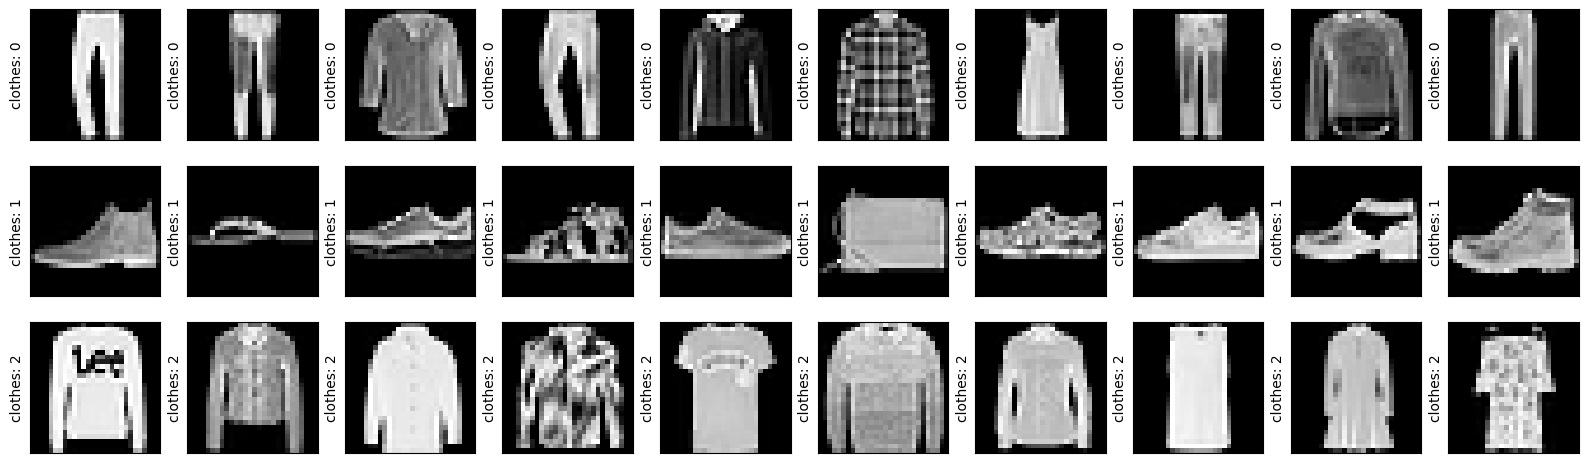

In [ ]:
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(len(birch_labels_enc)):
    for c, val in enumerate(X_test[birch_pred_labels_enc == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('clothes: '+str(clusterIdx))

#### Performance scores

In [ ]:
print('>>> Calculating performance scores for Birch clustering with encoded pixel values...')
birch_silh_score_norm, birch_ch_score_norm, birch_db_score_norm = performance_score(y_test.reshape(-1, 1), birch_labels_enc)
birch_vm_score_norm = metrics.v_measure_score(birch_labels_enc, birch_pred_labels_enc)
print(f' .. V-measure score is {birch_vm_score_norm}')

>>> Calculating performance scores for Birch clustering with encoded pixel values...
 .. Silhouette Coefficient score is 0.10
 .. Calinski-Harabasz Index score is 3707.04
 .. Davies-Bouldin Index score is 6.56
 .. V-measure score is 1.0


### Birch clustering (normalized pixel values)

In [ ]:
print('>>> Birch clustering...')

birch = cluster.Birch(threshold=0.1)
birch.fit(test_norm_images)
birch_labels_norm = birch.labels_
birch_pred_labels_norm = birch.fit_predict(test_norm_images)

print('>>> Birch clustering finished...')

>>> Birch clustering...
>>> Birch clustering finished...


#### Visualizations

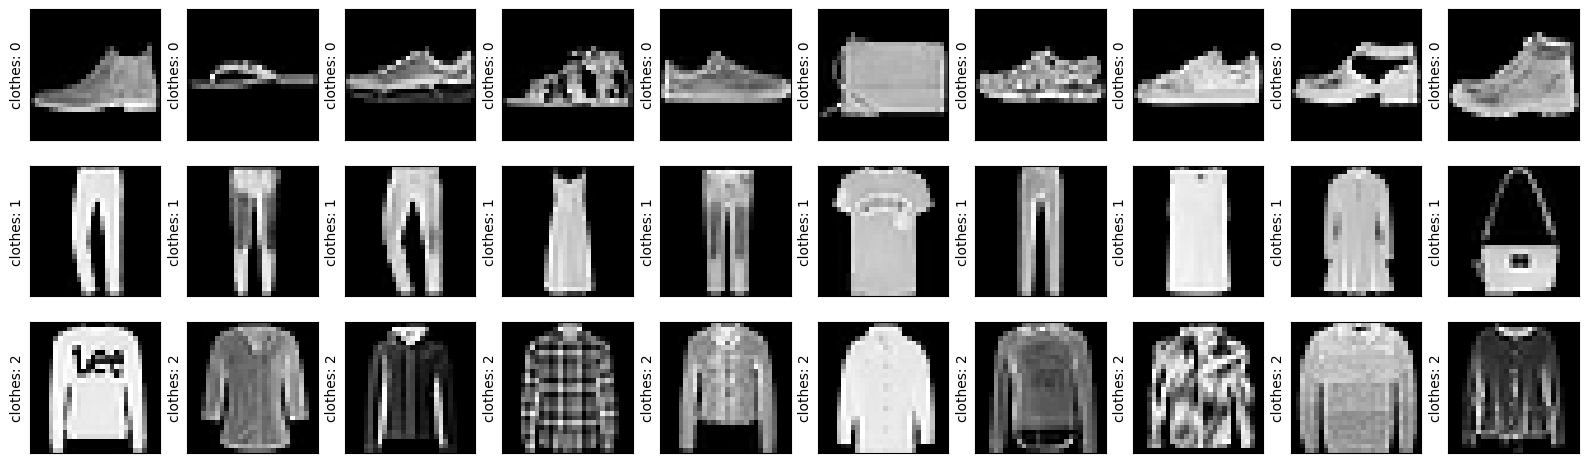

In [ ]:
fig = plt.figure(figsize=(20,20))
for clusterIdx in range(len(birch_labels_norm)):
    for c, val in enumerate(X_test[birch_pred_labels_norm == clusterIdx][0:10]):
        fig.add_subplot(10, 10, 10*clusterIdx+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('clothes: '+str(clusterIdx))

#### Performance scores

In [ ]:
print('>>> Calculating performance scores for Birch clustering with normalized pixel values...')
birch_silh_score_norm, birch_ch_score_norm, birch_db_score_norm = performance_score(y_test.reshape(-1, 1), birch_labels_norm)
birch_vm_score_norm = metrics.v_measure_score(birch_labels_norm, birch_pred_labels_norm)
print(f' .. V-measure score is {birch_vm_score_norm}')

>>> Calculating performance scores for Birch clustering with normalized pixel values...
 .. Silhouette Coefficient score is 0.16
 .. Calinski-Harabasz Index score is 5361.29
 .. Davies-Bouldin Index score is 1.48
 .. V-measure score is 1.0
